In [1]:
from dask.distributed import LocalCluster, Client
from dask import delayed, compute
from collections import OrderedDict

import dask.dataframe as dd
import fastparquet as fq

import multiprocessing as mp
import pandas as pd
import numpy as np
import time

In [2]:
to_read = input()

data/feb_wm2554.parq


In [3]:
data = fq.ParquetFile(to_read).to_pandas()

/Users/rkhullar/Lab/virtualenvs/data-science/lib/python3.6/site-packages/fastparquet/api.py:436: UserWarning: Regression warning: found category spec from fastparquet <= 0.0.6
  warnings.warn('Regression warning: found category spec from '


In [4]:
data.columns

Index(['index', 'inventory_item_id', 'dma', 'dma_us_coverage', 'daypart',
       'demo', 'program', 'station', 'station_affiliation', 'time', 'dealcost',
       'grossrate', 'mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun', 'month',
       'year', 'currentimp', 'imp', 'share', 'hut', 'ihh', 'pgname'],
      dtype='object')

In [7]:
data.head()

,index,inventory_item_id,dma,dma_us_coverage,daypart,demo,program,station,station_affiliation,time,...,sat,sun,month,year,currentimp,imp,share,hut,ihh,pgname
0,0,8ZfDS4mskgyJM6sWf,PHX AZ,1.648,LF,WM2554,LAST MAN STANDING,KTVK,IND,25:30-26:00,...,1,0,02,2017,0.8,0.790039,0.830078,95.250,3.419922,#LAST MN STN WK
1,1,hwXmymKYaGvHyGuTd,PHX AZ,1.648,LF,WM2554,PAWN STARS,KTVK,IND,23:30-24:00,...,1,0,02,2017,1.0,3.519531,1.759766,200.000,11.921875,#PAWN STARS-1 B
2,2,7KhcE5eJka9QBprNi,PHX AZ,1.648,EM,WM2554,MORNING NEWS,KTVK,IND,07:00-08:00,...,1,0,02,2017,9.9,11.843750,13.890625,85.250,63.562500,#GMAZ SAT 7AM
3,3,s4Wa4HJLdz6Zjfg2S,PHX AZ,1.648,DY,WM2554,LOCAL LIFESTYLE,KTVK,IND,10:00-11:00,...,0,0,02,2017,2.6,2.250000,1.620117,138.875,14.750000,#YOUR LIFE A-Z
4,4,qT5tXpTXnhFTdxgyn,PHX AZ,1.648,DY,WM2554,DY ROS,KTVK,IND,10:00-15:00,...,0,0,02,2017,2.5,2.910156,2.099609,138.500,16.843750,Various(none > 50%)


In [5]:
programs = list(data.program.unique())
programs.sort()
programs = pd.Series(programs)

In [12]:
q = input('search programs:')
mask = programs.str.startswith(q)
programs.loc[mask]

search programs:G


188               GAME ON
189             GAME SHOW
190      GENERAL HOSPITAL
191    GENESIS EXPERIENCE
192             GET SMART
193                GIDGET
194     GILLIGAN'S ISLAND
195                   GMA
196             GOLDBERGS
197            GOMER PYLE
198            GOOD TASTE
199            GOOD TIMES
200             GOOD WIFE
201       GREAT BIG WORLD
202             GREAT DAY
203           GREEN ACRES
204        GROWING BOLDER
205              GUNSMOKE
206      GUS BRADLEY SHOW
dtype: object

In [13]:
to_match = OrderedDict(year='2017', month='02', program='GOOD MORNING AMERICA', demo='WM2554', time='07:00-09:00', mon=1, tue=1, wed=1, thur=1, fri=1)
to_match = OrderedDict(program='MORNING NEWS', time='06:00-07:00', station_affiliation='CBS')

The following section compares query runtime with and without reduction. Building a chain of loc slows things down severely. The best time was without reduction.

In [14]:
%%time
frame, mask = data, np.ones(len(data)).astype(bool)
for k, v in to_match.items():
    t1 = time.time()
    #mask &= frame.loc[mask, k] == v
    mask &= data[k] == v
    frame = frame.loc[mask]
    t2 = time.time()
    #print(k, t2-t1)
frame.imp.sum()

CPU times: user 16.1 ms, sys: 1.7 ms, total: 17.8 ms
Wall time: 17.7 ms


In [15]:
%%time
mask = np.ones(len(data)).astype(bool)
for k, v in to_match.items():
    t1 = time.time()
    #mask &= data.loc[mask, k] == v
    mask &= data[k] == v
    t2 = time.time()
    #print(k, t2-t1)
frame = data.loc[mask]
frame.imp.sum()

CPU times: user 8.42 ms, sys: 667 µs, total: 9.09 ms
Wall time: 8.62 ms


time to daskify!

In [16]:
cluster = LocalCluster()

In [17]:
client = Client(cluster)

In [18]:
df = dd.from_pandas(data, npartitions=mp.cpu_count())

In [19]:
%%time
ddata = client.persist(df)

CPU times: user 703 µs, sys: 122 µs, total: 825 µs
Wall time: 800 µs


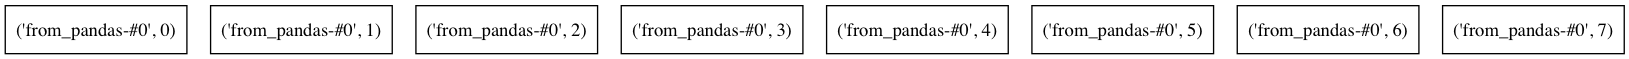

In [20]:
ddata.visualize()

In [21]:
#masks = [ddata.loc[:, k] == v for k, v in to_match.items()]
masks = [ddata[k] == v for k, v in to_match.items()]

In [22]:
mask = masks[0]
for m in masks[1:]:
    mask &= m

In [38]:
y = ddata.loc[mask, 'imp'].sum()

In [39]:
%%timeit
yy = y.compute()

84.5 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
yy

479.2451171875

manual sanity check and loc investigtaion

In [ ]:
%%timeit
m = data.loc[:, 'year'] == '2017'
m &= data.loc[m, 'month'] == '02'
m &= data.loc[m, 'demo'] == to_match['demo']
m &= data.loc[m, 'program'] == to_match['program']
m &= data.loc[m, 'time'] == '07:00-09:00'
data[m].imp.sum()

In [ ]:
%%timeit
m = data.year == '2017'
m &= data.month == '02'
m &= data.demo == to_match['demo']
m &= data.program == to_match['program']
m &= data.time == '07:00-09:00'
data[m].imp.sum()

let's investigate how to optimize queries manually

In [ ]:
clabels = [l for l, t in data.dtypes.items() if str(t) == 'category']
d = {label: len(data[label].cat.categories) for label in clabels}
s = pd.Series.from_array(d)

In [ ]:
s.sort_values(ascending=False, inplace=True)

In [ ]:
s

In [ ]:
%%timeit
m = True
m &= data.program == to_match['program']
m &= data.time == '07:00-09:00'
m &= data.demo == to_match['demo']
m &= data.month == '02'
m &= data.year == '2017'
data[m].imp.sum()

In [ ]:
%%timeit
f = data
m = f.program == to_match['program']
f = f[m]
m = f.time == '07:00-09:00'
f = f[m]
m = f.demo == to_match['demo']
f = f[m]
m = f.month == '02'
f = f[m]
m = f.year == '2017'
f = f[m]
f.imp.sum()

let's use built in pandas query engine

In [26]:
qstr = ' and '.join([f'{k}=="{v}"' for k, v in to_match.items()])

In [29]:
%%time
r = data.query(qstr)
r = r.imp.sum()
print(r)

479.245
CPU times: user 8.37 ms, sys: 1.85 ms, total: 10.2 ms
Wall time: 8.57 ms


In [35]:
%%time
y = ddata.query(qstr).imp.sum()
yy = y.compute()

CPU times: user 35 ms, sys: 8.84 ms, total: 43.9 ms
Wall time: 57.9 ms


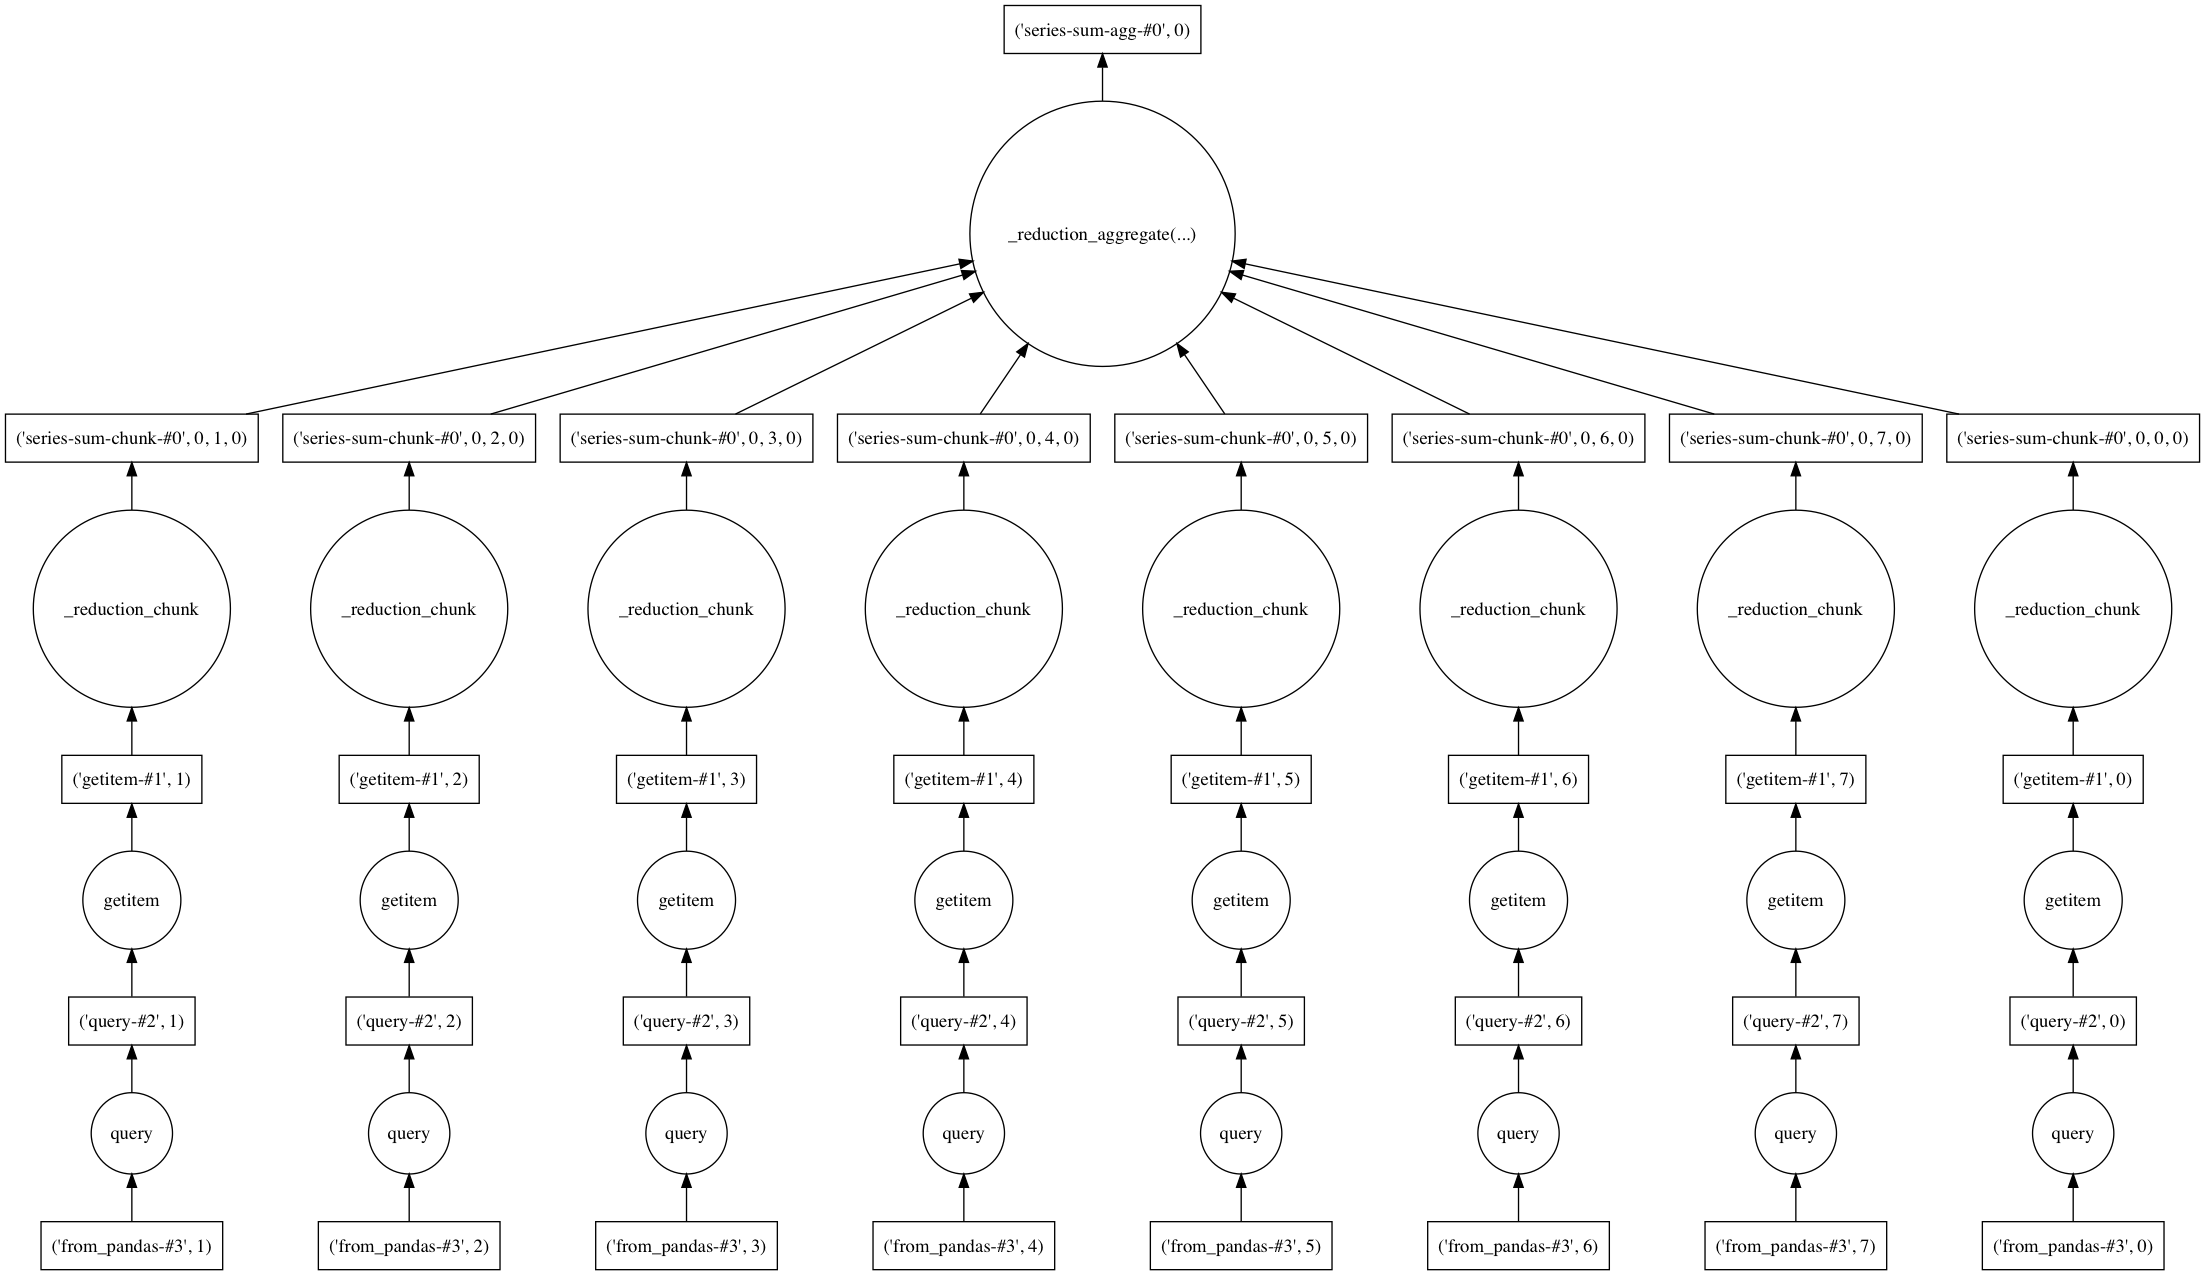

In [36]:
y.visualize()

In [37]:
yy

479.2451171875